<a href="https://colab.research.google.com/github/felixsimard/comp551-p2/blob/main/P2_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1: Optimization (80 points)**

## Setup

In [ ]:
# append the folder to the path
import sys
folder = '/content/drive/MyDrive/COMP551/mini2/'
if folder not in sys.path:
  sys.path.append(folder)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time
import pandas as pd
import numpy as np
import os
import joblib
import random

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed

# Additional Python files
from LogisticRegression import LogisticRegression, TrainingResults
from Gradient import *
LogisticRegression.gradient = gradient

In [ ]:
# Define datasets paths
diabetes_train_dir = '/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_train.csv'
diabetes_val_dir = '/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_val.csv'
diabetes_test_dir = r'/content/drive/MyDrive/COMP551/mini2/diabetes/diabetes_test.csv'

diabetes_train_df = pd.read_csv(diabetes_train_dir, engine="python", error_bad_lines=False)
diabetes_val_df = pd.read_csv(diabetes_val_dir, engine="python", error_bad_lines=False)
diabetes_test_df = pd.read_csv(diabetes_test_dir, engine="python", error_bad_lines=False)

## Feature-Target split

In [ ]:
# split into feature and target
diabetes_train_X =  diabetes_train_df.drop('Outcome', axis=1)
diabetes_train_y = diabetes_train_df.loc[:, 'Outcome']
diabetes_val_X = diabetes_val_df.drop('Outcome', axis=1)
diabetes_val_y = diabetes_val_df.loc[:, 'Outcome']
diabetes_test_X = diabetes_test_df.drop('Outcome', axis=1)
diabetes_test_y = diabetes_test_df.loc[:, 'Outcome']

## 3. Momentum
Add momentum to the gradient descent implementation. Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? Specifically, analyze the impact of momentum on the conver- gence speed and the quality of the final solution.

In [ ]:
def get_result(lr, max_iters=2e4, itv=1e2,
               batch_size=-1, max_epochs=-1, momentum=0):
    model = LogisticRegression(verbose=True, learning_rate=lr, max_iters=max_iters)
    result = model.fit_for_vis_complex2(diabetes_train_X, diabetes_train_y, diabetes_val_X, diabetes_val_y,
                                       itv, batch_size, max_epochs, momentum)
    return result

In [ ]:
# base configuration
itv = int(1e2)
lr = 1e-4
max_iters = 2e4

###Convergence speed in batch gradient descent

In [ ]:
%%time
full_batch_result = get_result(lr, max_iters, itv)
full_batch_grad = full_batch_result.grad_list_it

(600, 9)
learning rate: 0.0001
batch size: 600
terminated after 20000 iterations, with norm of the gradient equal to 0.03688797641062749
the weight found: [ 0.12707092  0.01360153 -0.03072391 -0.00098248  0.00157526 -0.00516213
  0.01310926 -0.0114703  -0.07150881]
time elapsed:  5.76 seconds

CPU times: user 5.68 s, sys: 84.7 ms, total: 5.76 s
Wall time: 5.75 s


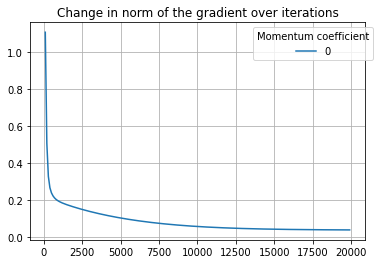

In [ ]:
# Create plot
length = len(full_batch_grad)
row = list(range(1, length*itv, itv))
plt.plot(row, full_batch_grad)
plt.legend(['0'], bbox_to_anchor=(1.04,1),
           title='Momentum coefficient')
plt.grid()
plt.title("Change in norm of the gradient over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_batch_grad.png', bbox_inches="tight")

### Try different momentum coefficients

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
momentum_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr, max_iters, itv, momentum=coeff) for coeff in coeffs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:   20.7s remaining:   10.4s


CPU times: user 199 ms, sys: 14.5 ms, total: 213 ms
Wall time: 30.8 s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   30.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   30.8s finished


In [ ]:
momentum_grads = [r.grad_list_it for r in momentum_results]
momentum_accs = [r.acc_list_it for r in momentum_results]

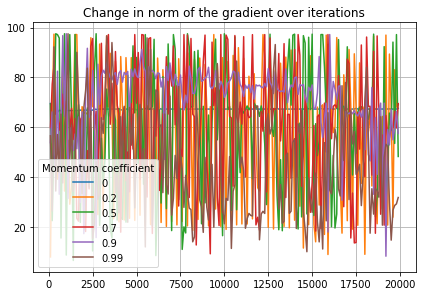

In [ ]:
# Create plot
my_list = momentum_grads
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.2', '0.5', '0.7', '0.9', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.tight_layout()
plt.title("Change in norm of the gradient over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_grads.png')

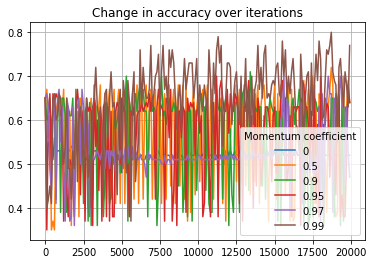

In [ ]:
# Create plot
my_list = momentum_accs
length = len(my_list[0])
row = list(range(1, length*itv, itv))
[plt.plot(row, my_list[i]) for i in range(len(my_list))]
plt.legend(['0', '0.5', '0.9', '0.95', '0.97', '0.99'],
           title='Momentum coefficient')
plt.grid()
plt.title("Change in accuracy over iterations")
plt.savefig('/content/drive/MyDrive/COMP551/mini2/figures/1_3_mom_accs.png')

## 4. Experiment momentum with mini-batch SGD
repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?

#####Smallest mini-batch: `batch_size`=8

In [ ]:
import random
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import pdb

In [ ]:
import random
import joblib

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_small_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=8, max_epochs=max_iters, momentum=coeff) for coeff in coeffs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed: 28.7min remaining: 14.3min


CPU times: user 11.4 s, sys: 1.43 s, total: 12.9 s
Wall time: 42min 48s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 42.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed: 42.8min finished


In [ ]:
joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_small_results.pkl')

['/content/drive/MyDrive/COMP551/mini2/objects/mini_small_results.pkl']

In [ ]:
def save_plot(input_result, lr, grad=True, bs='bs8'):
    # Create plot
    if grad:
        my_list = input_result.grad_list_epoch
        plt_title = 'norm of the gradient'
    else:
        my_list = input_result.acc_list_epoch
        plt_title = 'accuracy'
    length = len(my_list)
    row = list(range(1, length*itv, itv))
    plt.plot(row, my_list)
    plt.legend([str(lr)], bbox_to_anchor=(1.04,1),
            title='Momentum coefficient')
    plt.grid()
    plt.title("Change in " + plt_title + " over iterations")
    plt.savefig(f"{'/content/drive/MyDrive/COMP551/mini2/figures/1_3_' + bs + '_mini_grad_coeff0'+ str(int(lr*100)) + '.png'}", bbox_inches="tight")
    plt.show()


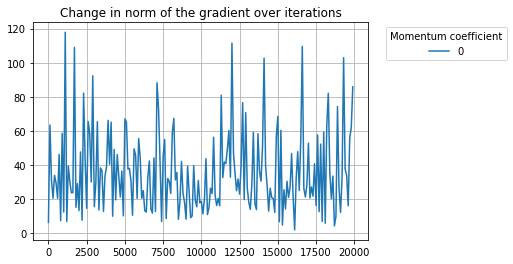

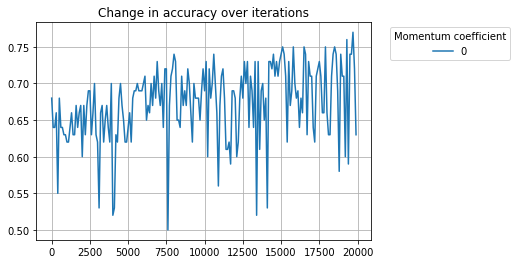

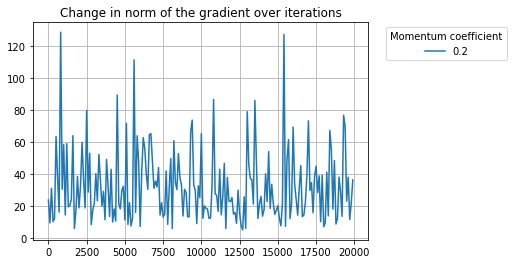

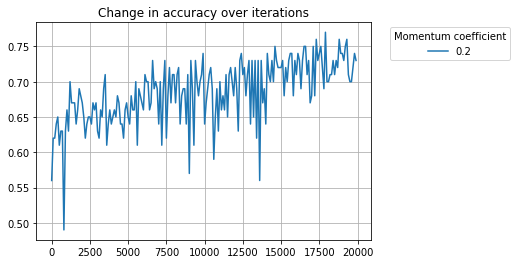

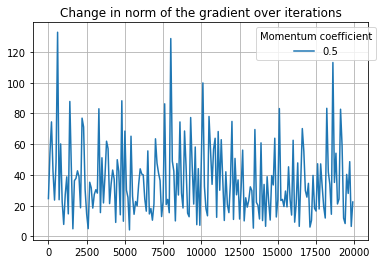

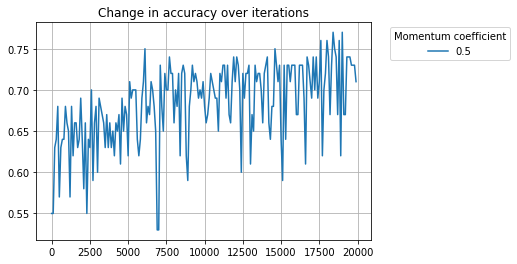

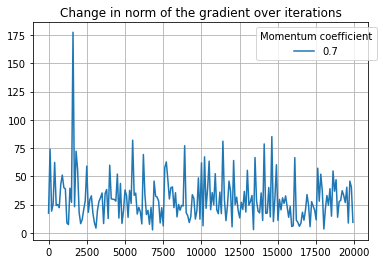

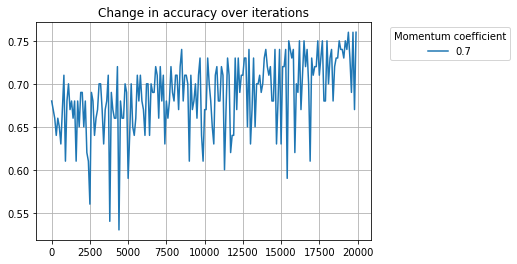

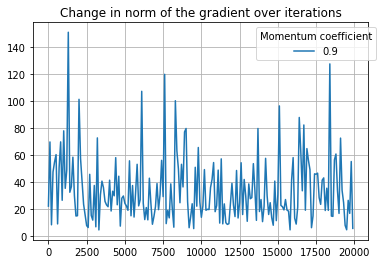

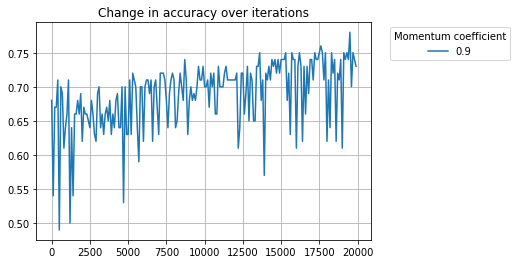

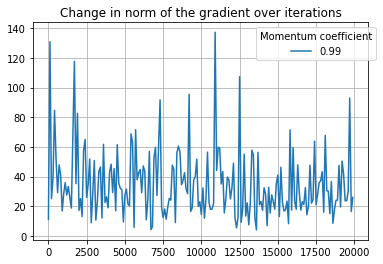

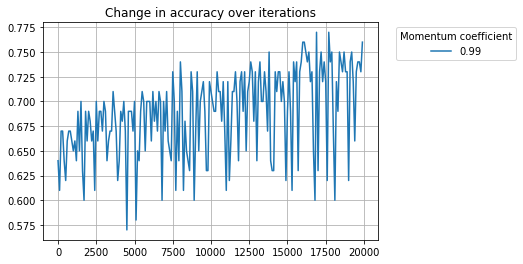

In [ ]:
for result, lr in zip(mini_small_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs8')
    save_plot(result, lr, grad=False, bs='bs8')

####Largest mini-batch: `batch_size`=512

In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
coeffs = [0, 0.2, 0.5, 0.7, 0.9, 0.99]
mini_large_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=512, max_epochs=max_iters, momentum=coeff) for coeff in coeffs)
joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/mini_large_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.8s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.5min remaining:   46.5s


CPU times: user 764 ms, sys: 77 ms, total: 841 ms
Wall time: 2min 18s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  2.3min finished


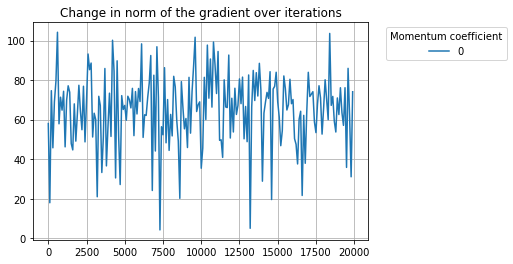

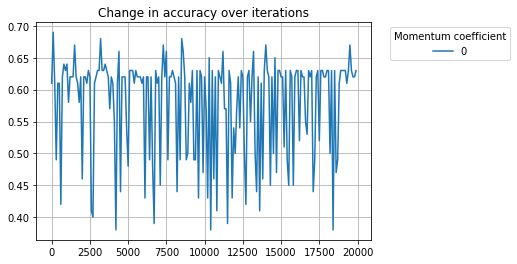

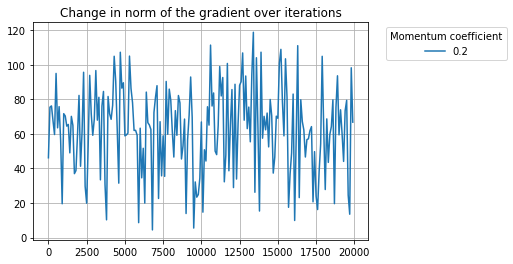

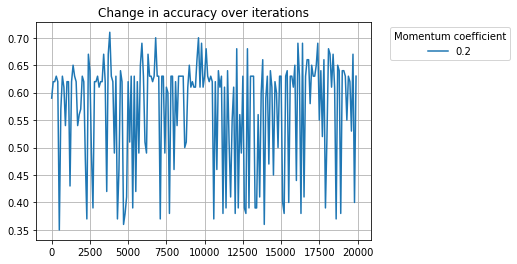

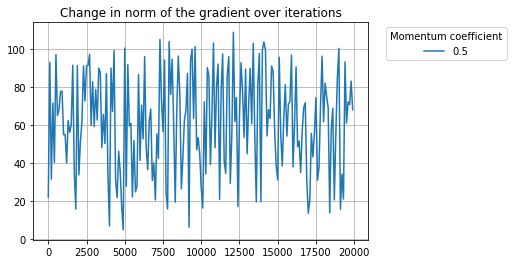

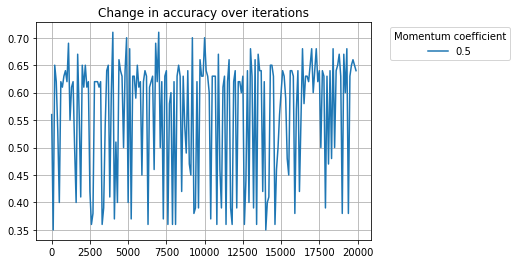

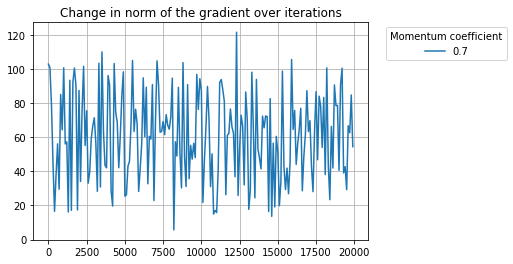

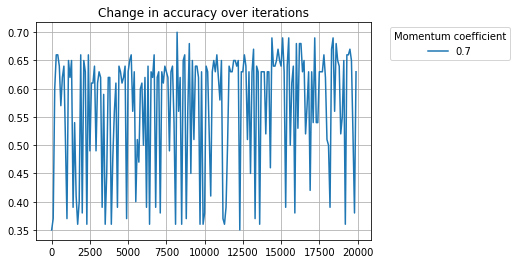

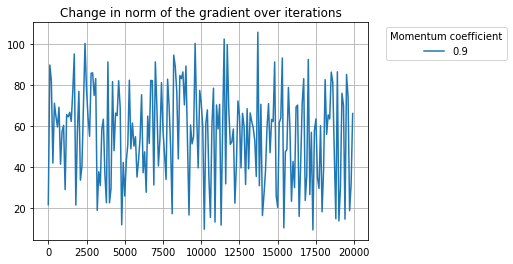

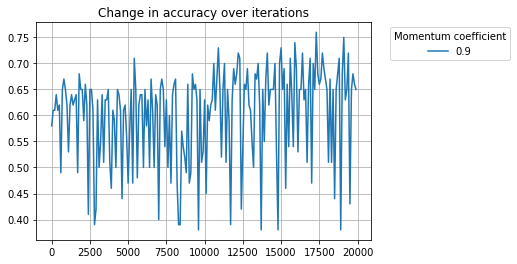

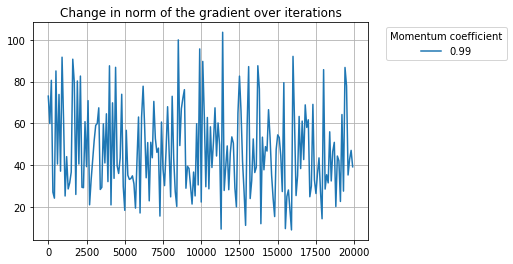

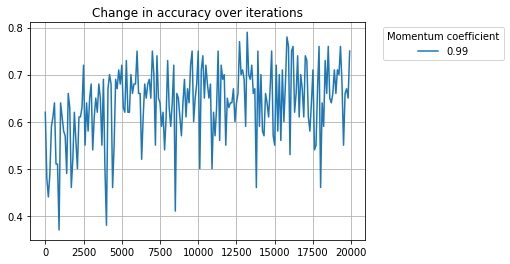

In [ ]:
for result, lr in zip(mini_large_results, [0, 0.2, 0.5, 0.7, 0.9, 0.99]):
    save_plot(result, lr, grad=True, bs='bs512')
    save_plot(result, lr, grad=False, bs='bs512')

###Batch gradient descent



In [ ]:
%%time
# Momentum added to LogisticRegression.py fit_for_vis_complex function
coeffs = [0, 0.88, 0.89, 0.9, 0.91, 0.85]
mini_large_results = Parallel(n_jobs=-1, verbose=10)(delayed(get_result)(lr,max_iters, itv,
                                                                       batch_size=600, max_epochs=max_iters, momentum=coeff) for coeff in coeffs)
#joblib.dump(mini_small_results, '/content/drive/MyDrive/COMP551/mini2/objects/batch_results.pkl')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done   4 out of   6 | elapsed:  1.1min remaining:   34.1s


CPU times: user 497 ms, sys: 50.6 ms, total: 547 ms
Wall time: 1min 42s


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.7min finished


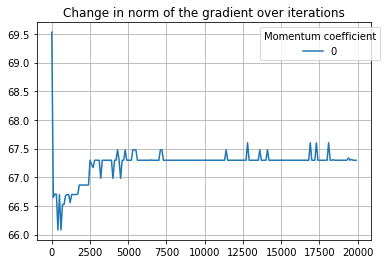

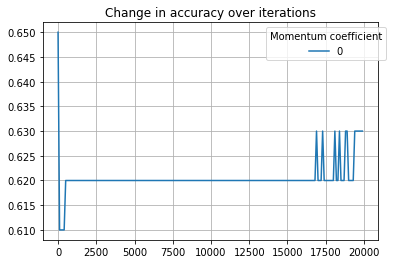

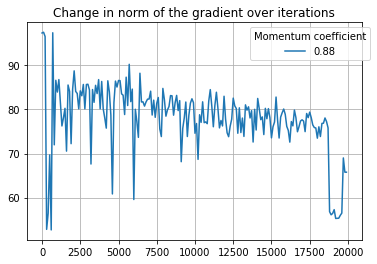

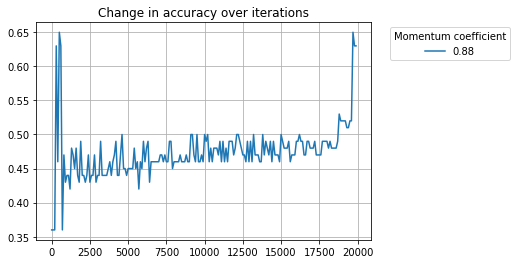

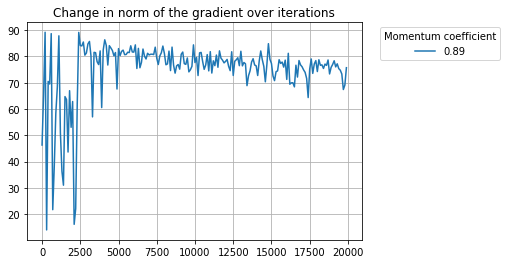

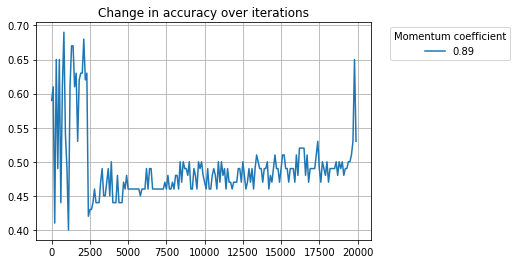

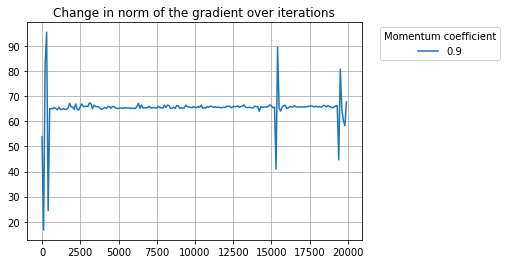

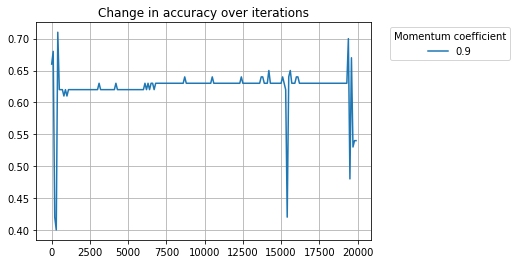

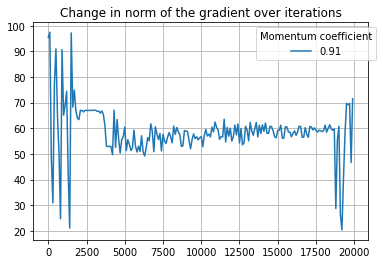

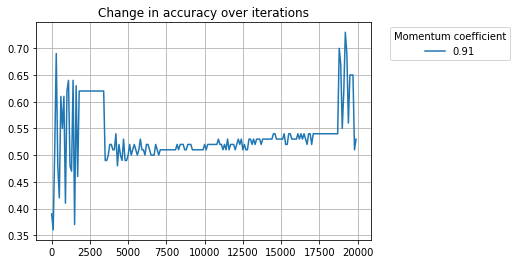

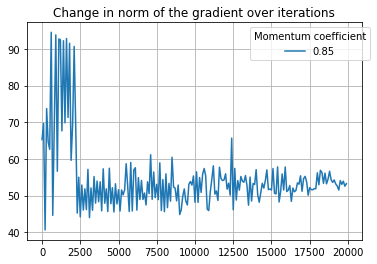

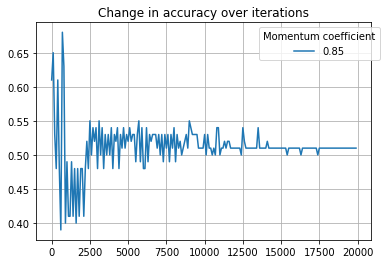

In [ ]:
for result, lr in zip(mini_large_results, [0, 0.88, 0.89, 0.9, 0.91, 0.85]):
    save_plot(result, lr, grad=True, bs='full')
    save_plot(result, lr, grad=False, bs='full')